In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths
EDGE_PATH = "../data/gossipcop/raw/A.txt"
INDICATOR_PATH = "../data/gossipcop/raw/node_graph_id.npy"
LABELS_PATH = "../data/gossipcop/raw/graph_labels.npy"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [3]:
# Graph Loader
def load_graphs(edge_path, indicator_path):
    edges = []
    with open(edge_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) == 2:
                try:
                    edges.append((int(parts[0]), int(parts[1])))
                except ValueError:
                    continue
    edge_index = np.array(edges).T
    graph_indicator = np.load(indicator_path)
    num_graphs = int(graph_indicator.max())
    graphs = [nx.Graph() for _ in range(num_graphs + 1)]

    for n, g_id in enumerate(graph_indicator):
        graphs[g_id].add_node(n)
    for src, dst in edge_index.T:
        graphs[graph_indicator[src]].add_edge(src, dst)

    return graphs[1:]


In [4]:
# Feature Extraction
def extract_graph_features(G):
    if len(G) == 0 or G.number_of_nodes() == 0:
        return [0] * 18

    degrees = dict(G.degree())
    deg_vals = list(degrees.values())
    degree_hist = np.bincount(deg_vals)
    deg_entropy = entropy(degree_hist, base=2)

    degree_centrality = list(nx.degree_centrality(G).values())
    betweenness_centrality = list(nx.betweenness_centrality(G).values())
    closeness_centrality = list(nx.closeness_centrality(G).values())
    harmonic_centrality = list(nx.harmonic_centrality(G).values())

    try:
        eigenvector_centrality = list(nx.eigenvector_centrality(G, max_iter=1000).values())
    except:
        eigenvector_centrality = [0] * G.number_of_nodes()

    if nx.is_connected(G):
        ecc = list(nx.eccentricity(G).values())
        avg_shortest_paths = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
        radius = nx.radius(G)
    else:
        ecc = [0]
        avg_shortest_paths = 0
        diameter = 0
        radius = 0

    return [
        G.number_of_nodes(), # Number of Nodes
        G.number_of_edges(), # Number of Edges
        np.mean(deg_vals), # Avg Degree
        nx.average_clustering(G), # Clustering Coeff
        nx.density(G), # Density
        nx.number_connected_components(G), # Num Components
        nx.degree_assortativity_coefficient(G), # Assortativity
        diameter, # Diameter
        radius, # Radius
        np.max(deg_vals), # Max Degree
        np.mean(degree_centrality), # Avg Degree Centrality
        np.mean(betweenness_centrality), # Avg Betweenness
        np.mean(closeness_centrality), # Avg Closeness
        np.mean(harmonic_centrality), # Avg Harmonic Centrality
        np.mean(eigenvector_centrality), # Avg Eigenvector Centrality
        np.mean(ecc), # Avg Eccentricity
        avg_shortest_paths, # Avg Shortest Path
        deg_entropy # Degree Entropy
    ]

def extract_all_features(graphs):
    return np.array([extract_graph_features(g) for g in graphs])

In [5]:
# Run Everything
print("Loading graphs...")
graphs = load_graphs(EDGE_PATH, INDICATOR_PATH)

print("Extracting features...")
features = extract_all_features(graphs)
print("Feature matrix shape:", features.shape)

print("Loading labels...")
raw_labels = np.load(LABELS_PATH)
labels = raw_labels[1:]  # Drop dummy
label_names = pd.Series(labels).map({0: "Fake", 1: "Real"})

Loading graphs...
Extracting features...
Feature matrix shape: (5463, 18)
Loading labels...


Class Distribution:
Label
Real    2732
Fake    2731
Name: count, dtype: int64


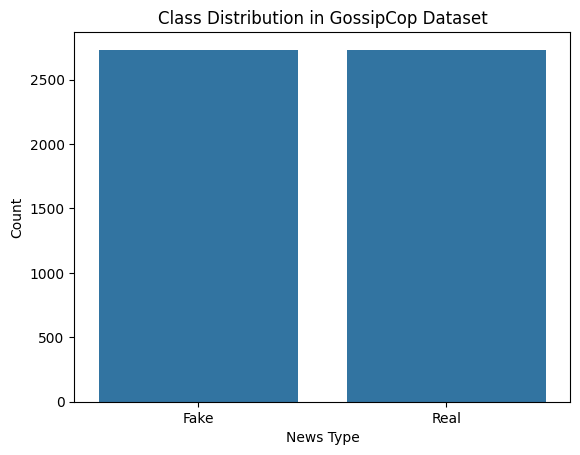

In [6]:
# DataFrame
feature_names = [
    "Num Nodes", "Num Edges", "Avg Degree", "Clustering Coefficient", "Density", "Num Components",
    "Assortativity", "Diameter", "Radius", "Max Degree", "Avg Degree Centrality", "Avg Betweenness",
    "Avg Closeness", "Avg Harmonic Centrality", "Avg Eigenvector Centrality", "Avg Eccentricity",
    "Path Length", "Degree Entropy"
]

df = pd.DataFrame(features, columns=feature_names)
df["Label"] = label_names[:features.shape[0]]

print("Class Distribution:")
print(df["Label"].value_counts())



# Save the DataFrame
np.save(os.path.join(RESULTS_DIR, "gossipcop_features_extended_18.npy"), features)
np.save(os.path.join(RESULTS_DIR, "gossipcop_labels.npy"), labels[:features.shape[0]])


# Class Balance Plot
sns.countplot(data=df, x="Label")
plt.title("Class Distribution in GossipCop Dataset")
plt.ylabel("Count")
plt.xlabel("News Type")
plt.show()